In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight

from evaluation import get_cm_sklearn, print_metrics
from preprocessing import TrainingPreProcessor

RANDOM_STATE = 0

train_set = pd.read_csv("input/train.csv")

training_preprocessor = TrainingPreProcessor()
training_preprocessor.fit(train_set, ignore_columns=["CLIENTNUM"])

X, y = training_preprocessor.transform(train_set)

class_weight = training_preprocessor.class_weight
xgb_class_weight = compute_sample_weight(class_weight='balanced', y=y)

In [2]:
xgboost_model = xgb.XGBClassifier(seed=RANDOM_STATE)

## Grid search

In [9]:
kfold = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)

grid_parameters = {
    "n_estimators": [100, 300, 500, 700, 900],
    "subsample": [0.2, 0.4, 0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.5, 1, 5, 10],
    "colsample_bytree": [0.9, 0.95, 1.0],
    "max_depth": [3, 7, 11, 15],
}

grid_search = GridSearchCV(
    xgboost_model,
    grid_parameters,
    scoring="balanced_accuracy",
    cv=kfold,
    verbose=3,
    n_jobs=-1,
)

In [11]:
grid_search.fit(X, y, sample_weight=xgb_class_weight)
print(grid_search.best_params_)
print(grid_search.best_score_)
grid_search.best_estimator_

Fitting 3 folds for each of 4500 candidates, totalling 13500 fits
{'colsample_bytree': 1.0, 'gamma': 1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
0.9595274202376629


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [12]:
grid_parameters_2 = {
    "n_estimators": [100, 150, 200, 250, 300],
    "subsample": [0.7, 0.75, 0.8, 0.85, 0.9],
    "min_child_weight": [2, 3, 4],
    "gamma": [0.75, 1, 3],
    "colsample_bytree": [0.95, 0.975, 1.0],
    "max_depth": [2, 3, 4],
}

grid_search_2 = GridSearchCV(
    xgboost_model,
    grid_parameters_2,
    scoring="balanced_accuracy",
    cv=kfold,
    verbose=3,
    n_jobs=-1,
)

In [14]:
grid_search_2.fit(X, y, sample_weight=xgb_class_weight)
print(grid_search_2.best_params_)
print(grid_search_2.best_score_)
grid_search_2.best_estimator_

Fitting 3 folds for each of 2025 candidates, totalling 6075 fits
{'colsample_bytree': 1.0, 'gamma': 3, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 250, 'subsample': 0.9}
0.9605273251543056


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [21]:
# {'colsample_bytree': 1.0, 'gamma': 3, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 250, 'subsample': 0.9}
best_model = grid_search_2.best_estimator_ 

In [22]:
best_model.fit(X, y, sample_weight=xgb_class_weight)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [23]:
test_set = pd.read_csv("input/test.csv")
X_test, y_test = training_preprocessor.transform(test_set)

### Avaliação do encontrado

Accuracy: 0.9634748272458046
Balanced Accuracy: 0.9621705878435417
F1: 0.9779104477611941
RoC AuC: 0.9621705878435416


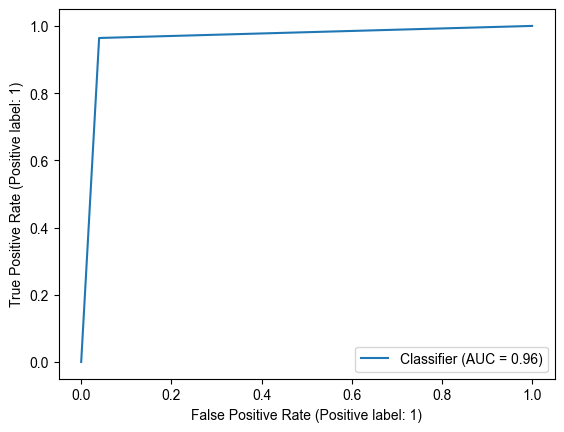

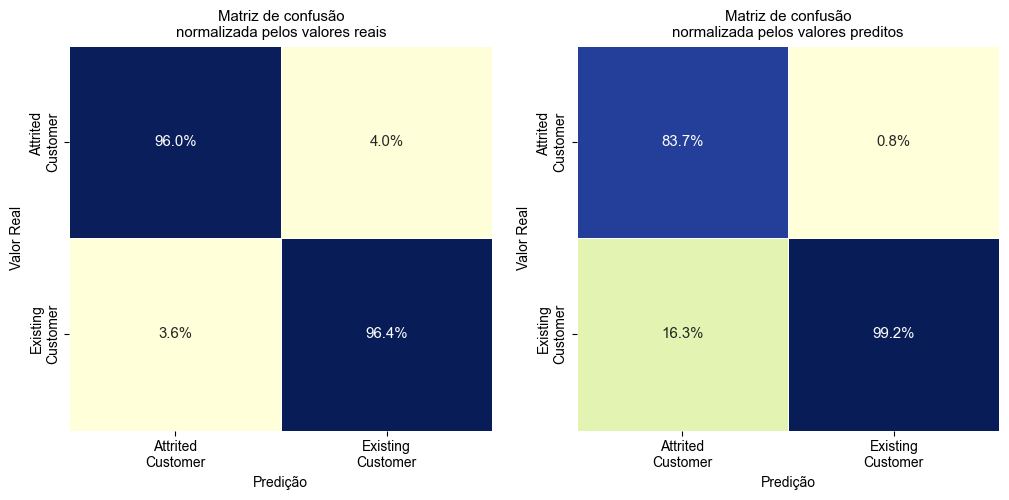

In [24]:
y_pred_test = best_model.predict(X_test)

print_metrics(y_test, y_pred_test)

get_cm_sklearn(
    y_test,
    y_pred_test,
    labels=[
        "\n".join(label.split())
        for label in training_preprocessor.label_encoder.classes_
    ],
)